# Bike Sharing Demand

<img src="../input/christian-stahl-xmGkzY--Fgg-unsplash.jpg" style="height:300px">

Photo by [Christian Stahl](https://unsplash.com/@woodpecker65)


## Context

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


## Goal
Forecast use of a city bikeshare system

---

# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [3]:
df = pd.read_csv("../input/train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.shape

(10886, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


The dataset contains the following columns:

```
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```

No Nan, it seems that there isn't any missing value. Let's see the basic statistics:

In [6]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


At first glance, it seems strange that no negative temperature is recorded...

## Weather informations analysis

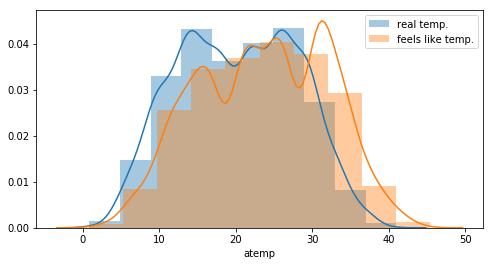

In [7]:
plt.figure(figsize=(8, 4))
sns.distplot(df.temp, bins=10, label='real temp.')
sns.distplot(df.atemp, bins=10, label='feels like temp.')
plt.legend()
plt.show()

One can see an offset between the real temperature and the "feels like" temperature. This can probably explained by the fact that temperature on a bike is different. But the distributions looks the same. More, there is a clear correlation between the 2 features.

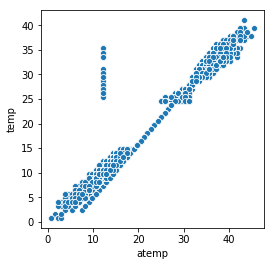

In [8]:
plt.figure(figsize=(4, 4))
sns.scatterplot(df.atemp, df.temp)
plt.show()

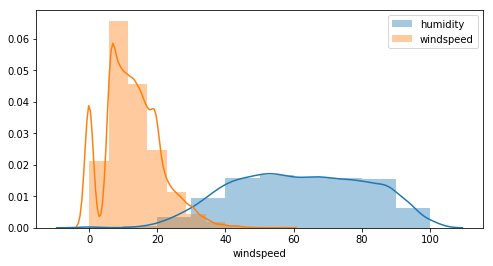

In [9]:
plt.figure(figsize=(8, 4))
sns.distplot(df.humidity, bins=10, label='humidity')
sns.distplot(df.windspeed, bins=10, label='windspeed')
plt.legend()
plt.show()

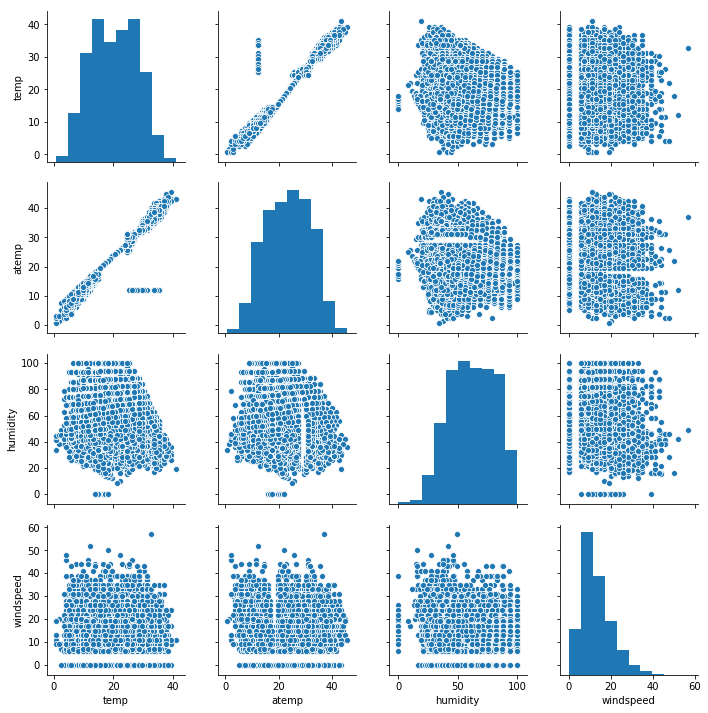

In [10]:
sns.pairplot(df[['temp', 'atemp', 'humidity', 'windspeed']])

Except for the temperature, there is no clear correlation between other features.

## Modification of time data

In [11]:
df['casual_percentage'] = df['casual'] / df['count']
df['registered_percentage'] = df['registered'] / df['count']

In [12]:
def change_datetime(df):
    """ Modify the col datetime to create other cols: dow, month, week..."""
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["dow"] = df["datetime"].dt.dayofweek
    df["month"] = df["datetime"].dt.month
    df["week"] = df["datetime"].dt.week
    df["hour"] = df["datetime"].dt.hour
    df["year"] = df["datetime"].dt.year
    df["season"] = df.season.map({1: "Winter", 2 : "Spring", 3 : "Summer", 4 :"Fall" })
    df["month_str"] = df.month.map({1: "Jan ", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec" })
    df["dow_str"] = df.dow.map({5: "Sat", 6 : "Sun", 0 : "Mon", 1 :"Tue", 2 : "Wed", 3 : "Thu", 4: "Fri" })
    df["weather_str"] = df.weather.map({1: "Good", 2 : "Normal", 3 : "Bad", 4 :"Very Bad"})
    return df
    
    
df = change_datetime(df)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_percentage,registered_percentage,dow,month,week,hour,year,month_str,dow_str,weather_str
0,2011-01-01 00:00:00,Winter,0,0,1,9.84,14.395,81,0.0,3,13,16,0.187500,0.812500,5,1,52,0,2011,Jan,Sat,Good
1,2011-01-01 01:00:00,Winter,0,0,1,9.02,13.635,80,0.0,8,32,40,0.200000,0.800000,5,1,52,1,2011,Jan,Sat,Good
2,2011-01-01 02:00:00,Winter,0,0,1,9.02,13.635,80,0.0,5,27,32,0.156250,0.843750,5,1,52,2,2011,Jan,Sat,Good
3,2011-01-01 03:00:00,Winter,0,0,1,9.84,14.395,75,0.0,3,10,13,0.230769,0.769231,5,1,52,3,2011,Jan,Sat,Good
4,2011-01-01 04:00:00,Winter,0,0,1,9.84,14.395,75,0.0,0,1,1,0.000000,1.000000,5,1,52,4,2011,Jan,Sat,Good


## Rentals analysis

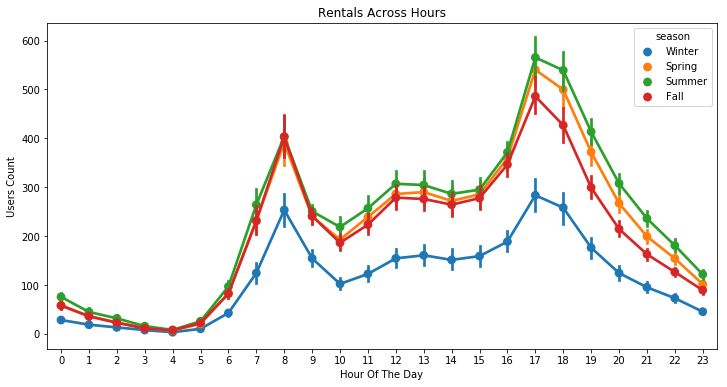

In [13]:
plt.figure(figsize=(12, 6))
sns.pointplot(x=df["hour"], y=df["count"], hue=df["season"])
plt.xlabel("Hour Of The Day")
plt.ylabel("Users Count") 
plt.title("Rentals Across Hours")
plt.show()

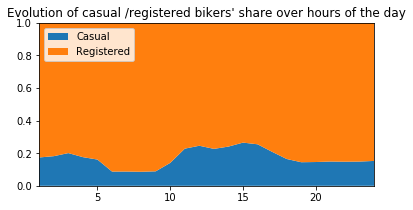

<Figure size 432x432 with 0 Axes>

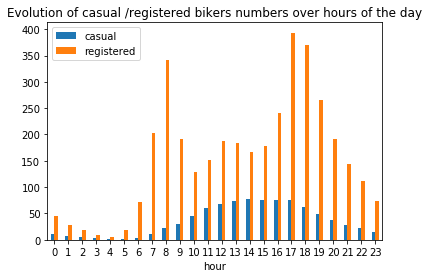

In [14]:
# ---------------------------------------------------------
plt.figure(figsize=(6,3))
plt.stackplot(range(1,25),
              df.groupby(['hour'])['casual_percentage'].mean(), 
              df.groupby(['hour'])['registered_percentage'].mean(), 
              labels=['Casual','Registered'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title("Evolution of casual /registered bikers' share over hours of the day")

# ---------------------------------------------------------
plt.figure(figsize=(6,6))
df_hours = pd.DataFrame(
    {"casual" : df.groupby(['hour'])['casual'].mean().values,
    "registered" : df.groupby(['hour'])['registered'].mean().values},
    index = df.groupby(['hour'])['casual'].mean().index)
df_hours.plot.bar(rot=0)
plt.title("Evolution of casual /registered bikers numbers over hours of the day")

# ---------------------------------------------------------
plt.show()

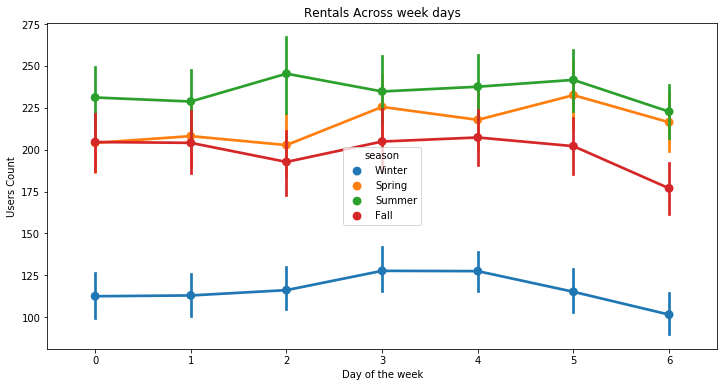

In [15]:
plt.figure(figsize=(12, 6))
sns.pointplot(x=df["dow"], y=df["count"], hue=df["season"])
plt.xlabel("Day of the week")
plt.ylabel("Users Count") 
plt.title("Rentals Across week days")
plt.show()

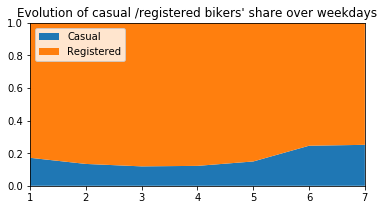

<Figure size 432x432 with 0 Axes>

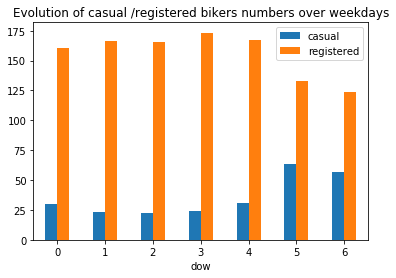

In [17]:
# ---------------------------------------------------------
plt.figure(figsize=(6,3))
plt.stackplot(range(1,8),
              df.groupby(['dow'])['casual_percentage'].mean(), 
              df.groupby(['dow'])['registered_percentage'].mean(), 
              labels=['Casual','Registered'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title("Evolution of casual /registered bikers' share over weekdays")

# ---------------------------------------------------------
plt.figure(figsize=(6,6))
df_hours = pd.DataFrame(
    {"casual" : df.groupby(['dow'])['casual'].mean().values,
    "registered" : df.groupby(['dow'])['registered'].mean().values},
    index = df.groupby(['dow'])['casual'].mean().index)
df_hours.plot.bar(rot=0)
plt.title("Evolution of casual /registered bikers numbers over weekdays")

# ---------------------------------------------------------
plt.show()

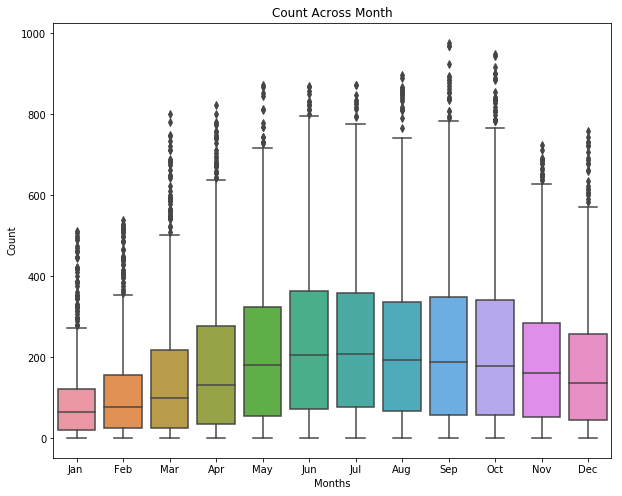

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y="count", x="month_str", orient="v")
ax.set(xlabel="Months" , ylabel="Count", title="Count Across Month");

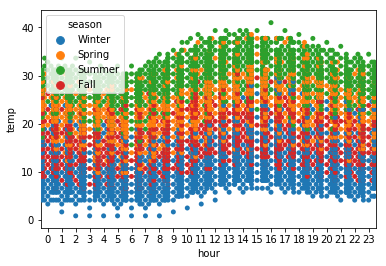

In [19]:
sns.swarmplot(x='hour', y='temp', data=df, hue='season')
plt.show()

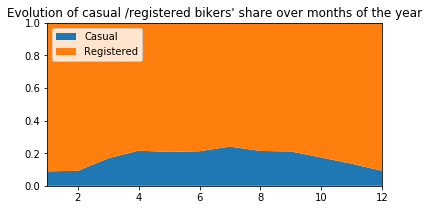

<Figure size 432x432 with 0 Axes>

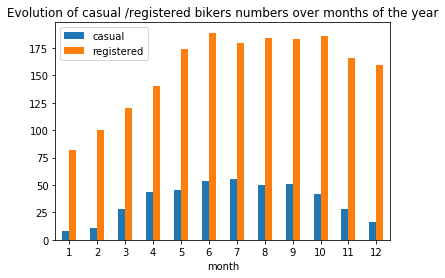

In [20]:
# ---------------------------------------------------------
plt.figure(figsize=(6,3))
plt.stackplot(range(1,13),
              df.groupby(['month'])['casual_percentage'].mean(), 
              df.groupby(['month'])['registered_percentage'].mean(), 
              labels=['Casual','Registered'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title("Evolution of casual /registered bikers' share over months of the year")

# ---------------------------------------------------------
plt.figure(figsize=(6,6))
df_hours = pd.DataFrame(
    {"casual" : df.groupby(['month'])['casual'].mean().values,
    "registered" : df.groupby(['month'])['registered'].mean().values},
    index = df.groupby(['month'])['casual'].mean().index)
df_hours.plot.bar(rot=0)
plt.title("Evolution of casual /registered bikers numbers over months of the year")

# ---------------------------------------------------------
plt.show()

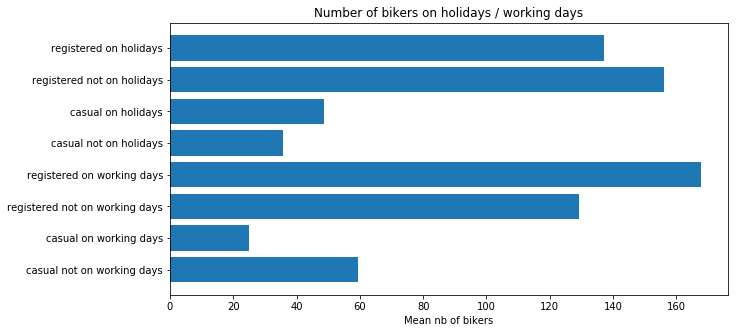

In [21]:
plt.figure(figsize=(10, 5))

bars = ['casual not on working days', 'casual on working days',\
        'registered not on working days', 'registered on working days',\
        'casual not on holidays', 'casual on holidays',\
        'registered not on holidays', 'registered on holidays']

qty = [df.groupby(['workingday'])['casual'].mean()[0], df.groupby(['workingday'])['casual'].mean()[1],\
      df.groupby(['workingday'])['registered'].mean()[0], df.groupby(['workingday'])['registered'].mean()[1],\
      df.groupby(['holiday'])['casual'].mean()[0], df.groupby(['holiday'])['casual'].mean()[1],\
      df.groupby(['holiday'])['registered'].mean()[0], df.groupby(['holiday'])['registered'].mean()[1]]

y_pos = np.arange(len(bars))
plt.barh(y_pos, qty, align='center')

plt.yticks(y_pos, labels=bars)
#plt.invert_yaxis()  # labels read top-to-bottom
plt.xlabel('Mean nb of bikers')
plt.title("Number of bikers on holidays / working days")
plt.show()

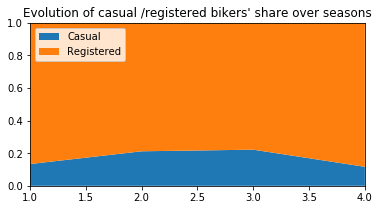

<Figure size 432x432 with 0 Axes>

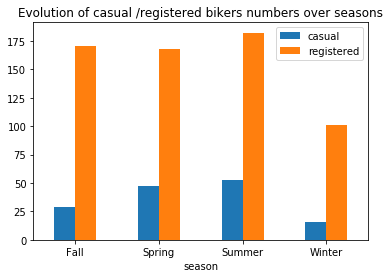

In [22]:
# ---------------------------------------------------------
plt.figure(figsize=(6,3))
plt.stackplot(range(1,5),
              df.groupby(['season'])['casual_percentage'].mean(), 
              df.groupby(['season'])['registered_percentage'].mean(), 
              labels=['Casual','Registered'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title("Evolution of casual /registered bikers' share over seasons")

# ---------------------------------------------------------
plt.figure(figsize=(6,6))
df_hours = pd.DataFrame(
    {"casual" : df.groupby(['season'])['casual'].mean().values,
    "registered" : df.groupby(['season'])['registered'].mean().values},
    index = df.groupby(['season'])['casual'].mean().index)
df_hours.plot.bar(rot=0)
plt.title("Evolution of casual /registered bikers numbers over seasons")

# ---------------------------------------------------------
plt.show()

## Correlations

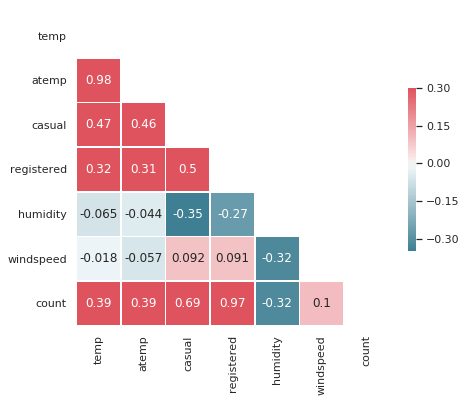

In [23]:
sns.set(style="white")

# Compute the correlation matrix
corr = df[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

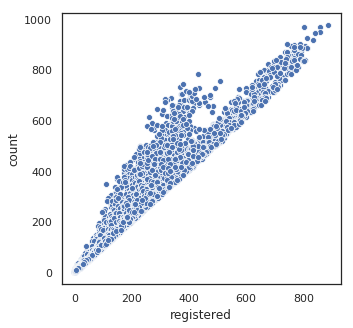

In [24]:
plt.figure(figsize=(5, 5))
sns.scatterplot(df.registered, df['count'])
plt.show()

## Data preparation for models

In [25]:
# target 
y = np.log1p(df["count"])

# drop irrelevant cols and target
cols_dropped = ["count", "datetime", "atemp", "month_str", "season", "dow_str", "weather_str",\
                "casual", "registered", "casual_percentage", "registered_percentage"]
X = df.drop(columns=cols_dropped)
            
X.shape, y.shape

((10886, 11), (10886,))

In [26]:
y.head()

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

In [27]:
X.head()

,holiday,workingday,weather,temp,humidity,windspeed,dow,month,week,hour,year
0,0,0,1,9.84,81,0.0,5,1,52,0,2011
1,0,0,1,9.02,80,0.0,5,1,52,1,2011
2,0,0,1,9.02,80,0.0,5,1,52,2,2011
3,0,0,1,9.84,75,0.0,5,1,52,3,2011
4,0,0,1,9.84,75,0.0,5,1,52,4,2011


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

---

# Models training and predictions

## Metric  - Root Mean Squared Logarithmic Error

Using logarithmic is an indirect way of measuring the performance of a loss function in terms of something more easily understandable

In [29]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Linear Regression Model

In [30]:
lr = LinearRegression().fit(X_train, y_train)
lr_err = rmsle(y_test, lr.predict(X_test))
print(f"RMSLE for Linear Regression: {lr_err:.4f}")

RMSLE for Linear Regression: 0.9703


## Random Forrest Regressor

In [31]:
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf_err = rmsle(y_test, rf.predict(X_test))
print(f"RMSLE for Random Forrest Reg: {rf_err:.4f}")

RMSLE for Random Forrest Reg: 0.2883


## Features importance

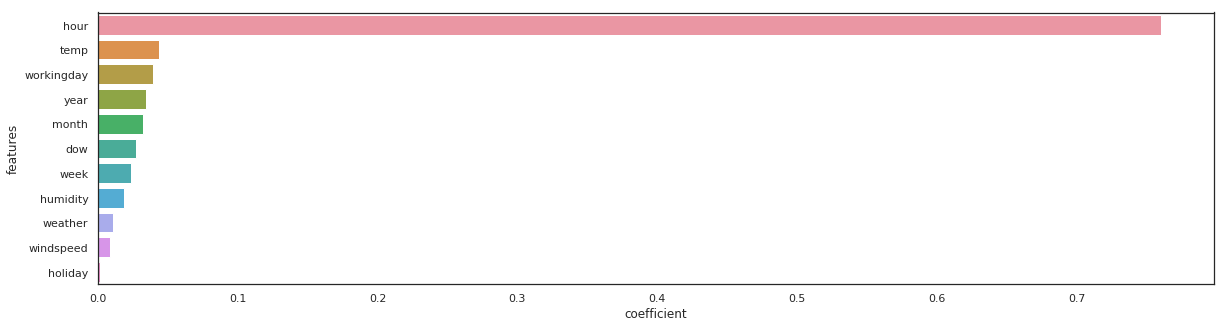

In [32]:
features = pd.DataFrame()
features["features"] = X_train.columns
features["coefficient"] = rf.feature_importances_

features.sort_values(by=["coefficient"], ascending=False, inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=features, x="coefficient", y="features");

## GradientBoosting Regressor

In [33]:
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01).fit(X_train, y_train)
gb_err = rmsle(y_test, gbm.predict(X_test))
print(f"RMSLE for GradientBoosting Reg: {gb_err:.4f}")

RMSLE for GradientBoosting Reg: 0.2740


## Ridge

In [35]:
rd = Ridge()
rd_params_ = {'max_iter':[1000, 2000, 3000],
                 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
rd = GridSearchCV(rd,
                  rd_params_,
                  scoring = rmsle_scorer,
                  cv=5)

In [36]:
rd.fit(X_train, y_train).best_params_

{'alpha': 30, 'max_iter': 1000}

In [37]:
rd_err = rmsle(y_test, rd.predict(X_test))
print(f"RMSLE for Ridge: {rd_err:.4f}")

RMSLE for Ridge: 0.9703


## Lasso

In [38]:
la = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
la_params = {'max_iter':[1000, 2000, 3000],'alpha':alpha}

la = GridSearchCV(la, la_params, scoring = rmsle_scorer, cv=5)
la.fit(X_train, y_train).best_params_

{'alpha': 0.005, 'max_iter': 1000}

In [39]:
la_err = rmsle(y_test, la.predict(X_test))
print(f"RMSLE for Lasso: {la_err:.4f}")

RMSLE for Lasso: 0.9704


---

# Conclusion and submission 

Before making a submission we have to choose the best model i.e with the smallest RMSLE. It's the GradientBoosting Regressor.

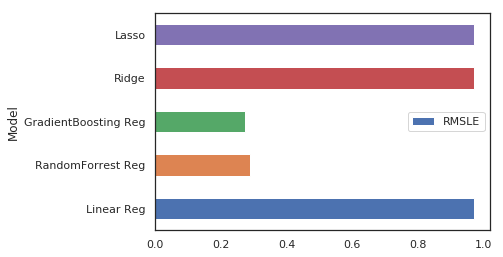

In [69]:
df_score = pd.DataFrame({'Model':['Linear Reg', 'RandomForrest Reg', 'GradientBoosting Reg', 'Ridge', 'Lasso'], 
                         'RMSLE':[lr_err, rf_err, gb_err, rd_err, la_err]})
ax = df_score.plot.barh(y='RMSLE', x='Model')

In [42]:
y_sample = pd.read_csv("../input/sampleSubmission.csv")
y_sample.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [58]:
df_test = pd.read_csv("../input/test.csv")
df_test = change_datetime(df_test)

# keep this col for the submission
datetimecol = df_test["datetime"]

test_cols_dropped = ['datetime',
 'atemp',
 'month_str',
 'season',
 'dow_str',
 'weather_str']

df_test = df_test.drop(columns=test_cols_dropped)
df_test.head()

,holiday,workingday,weather,temp,humidity,windspeed,dow,month,week,hour,year
0,0,1,1,10.66,56,26.0027,3,1,3,0,2011
1,0,1,1,10.66,56,0.0000,3,1,3,1,2011
2,0,1,1,10.66,56,0.0000,3,1,3,2,2011
3,0,1,1,10.66,56,11.0014,3,1,3,3,2011
4,0,1,1,10.66,56,11.0014,3,1,3,4,2011


In [59]:
y_pred_final = np.exp(gbm.predict(df_test))

In [60]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in y_pred_final]
    })
submission.to_csv('bike_prediction_output.csv', index=False)

submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.904386
1,2011-01-20 01:00:00,5.610445
2,2011-01-20 02:00:00,4.341828
3,2011-01-20 03:00:00,2.618222
4,2011-01-20 04:00:00,2.045243


Submit to kaggle, this model scores 0.41233. Not bad :)